### analysis/plot_model_outputs.ipynb

For the model chosen from the parameter sweep (where ORN columns are scaled by 0.1, eLNs by 0.04, iLNs by 0.02, and PNs by 0.4), plots:
- raster of all neurons
- firing rates of all neurons
- firing rates of ORNs & PNs to compare to experimental values in [Bhandawat et al 2007](https://doi.org/10.1038/nn1976)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.spatial.distance import pdist

In [2]:
import os
import sys
file_path = 'C:/Users/dB/deBivort/projects/ALVariability/analysis/plot_model_outputs.ipynb'
project_dir = os.path.join(file_path.split('ALVariability')[0], 'ALVariability')
sys.path.append(project_dir)

from utils.data_utils import make_df_AL_activity_long, make_orn_upn_frs, make_glomerular_odor_responses
from utils.plot_utils import set_font_sizes
from utils.plot_utils_EXTRA import plot_sim_raster, plot_mini_raster
from utils.odor_utils import load_door_data

set_font_sizes()

In [3]:
from utils.data_utils import get_AL_activity_dfs, \
    make_d_neur_inputs, make_orn_upn_frs, make_glomerular_odor_responses, make_df_AL_activity_long
from utils.make_output_figures import plot_sim_spikes2, plot_neur_I_contribs, plot_psths, \
    plot_synapse_scale_hmap

In [4]:
# load simulation 
jdir = '../run_model/save_sims_sensitivity_sweep/2021_8_19-5_25_2__0v12_all0.1_ecol0.4_icol0.2_pcol4.0_sweep_Bhandawat_odors_5_25_2/'

In [5]:
from datetime import datetime
import pickle
import re

In [6]:
thermo_hygro_glomeruli = np.array(['VP1d', 'VP1l', 'VP1m', 'VP2', 'VP3', 'VP4', 'VP5'])

# get list of files
jdir_files = os.listdir(jdir)
# get time tag
jdir = os.path.abspath(jdir)
time_tag_re = re.findall('(\d+)\_(\d+)\_(\d+)-(\d+)\_(\d+)\_(\d+)', jdir)[0]
time_tag = datetime(*[int(t) for t in time_tag_re])
run_tag = os.path.basename(os.path.normpath(jdir))
spliton = '__0v12'
job_tag = spliton + jdir.split(spliton)[1]
job_tag = job_tag.strip('/')
# get seed dict for params
jdir_params_seed = pickle.load(open(os.path.join(jdir, 'sim_params_seed.p'), 'rb'))
# get synapse dictionary
job_synapse_ws = jdir_params_seed['custom_scale_dic']

In [7]:
# load simulation outputs
sim_output = pickle.load(open(os.path.join(jdir, 'sim_output.p'), 'rb'))
sim = sim_output['sim']
V = sim_output['V']
I = sim_output['I'].toarray()
Iin = sim_output['Iin'].toarray()
Spikes = sim_output['Spikes'].toarray()
odor_names = [r[0] for r in sim.odor_list]

In [8]:
pdf_folder_name = 'model_outputs_2021-09-02'
if not os.path.exists(pdf_folder_name):
    os.makedirs(pdf_folder_name)

In [9]:
DPI = 250

savepicsdir = os.path.join(jdir, pdf_folder_name)
if not os.path.exists(savepicsdir):
    os.makedirs(savepicsdir)

df_AL_activity, df_AL_activity_long = get_AL_activity_dfs(sim, Spikes)
# remove non olfactory glomeruli
df_AL_activity_long = df_AL_activity_long[~df_AL_activity_long.glom.isin(thermo_hygro_glomeruli)]
df_neur_ids = sim.df_neur_ids.copy()

In [10]:
df_orn_frs, df_upn_frs = make_orn_upn_frs(df_AL_activity, odor_names, df_neur_ids,
                                          sub_pre=True, olf_only=True)
df_orn_glom_onoff, df_upn_glom_onoff = make_glomerular_odor_responses(df_orn_frs, df_upn_frs, df_AL_activity)

In [11]:
savepdfstoo=False

In [12]:
# plot Bhandawat version
bhand_gloms = ['DL1', 'DM1', 'DM2', 'DM3', 'DM4', 'VA2']
df_neur_ids_bhand  = df_neur_ids.copy()[((df_neur_ids.altype == 'ORN') & (df_neur_ids.glom.isin(bhand_gloms))) | 
          (df_neur_ids.altype == 'LN') | 
           ((df_neur_ids.altype == 'uPN') & (df_neur_ids.glom.isin(bhand_gloms))) |
           (df_neur_ids.altype == 'mPN')
          ]
df_AL_activity_bhand  = df_AL_activity.copy()[((df_AL_activity.neur_type == 'ORN') & (df_AL_activity.glom.isin(bhand_gloms))) | 
      (df_AL_activity.neur_type.isin(['iLN', 'eLN'])) | 
       ((df_AL_activity.neur_type == 'uPN') & (df_AL_activity.glom.isin(bhand_gloms))) |
       (df_AL_activity.neur_type == 'mPN')
      ]
df_AL_activity_long_bhand = make_df_AL_activity_long(df_AL_activity_bhand)
df_orn_frs_bhand, df_upn_frs_bhand = make_orn_upn_frs(df_AL_activity_bhand, 
                                                      odor_names, 
                                                      df_neur_ids_bhand.reset_index(),
                                                      sub_pre=True, olf_only=True)
df_orn_glom_onoff_bhand, df_upn_glom_onoff_bhand = \
    make_glomerular_odor_responses(df_orn_frs_bhand, df_upn_frs_bhand, df_AL_activity_bhand)

In [13]:
df_orn_glom_onoff_bhand

,benzaldehyde,butyric acid,"2,3-butanedione",1-butanol,cyclohexanone,Z3-hexenol,ethyl butyrate,ethyl acetate,geranyl acetate,isopentyl acetate,4-methylphenol,methyl salicylate,3-methylthio-1-propanol,octanal,2-octanone,pentyl acetate,E2-hexenal,gamma-valerolactone
glom,,,,,,,,,,,,,,,,,,
DL1,62.369048,37.184524,2.601190,5.255952,-4.113095,3.500000,7.815476,8.101190,6.880952,119.910714,71.755952,189.077381,11.458333,21.261905,65.232143,11.446429,6.827381,50.476190
DM1,14.720930,-5.947674,85.476744,5.825581,12.226744,41.645349,130.052326,165.970930,9.313953,58.604651,5.174419,4.930233,-7.197674,14.279070,-9.348837,75.447674,12.377907,-9.668605
DM2,30.803797,56.740506,48.873418,80.784810,-10.348101,16.867089,115.341772,58.025316,-2.405063,128.367089,42.582278,9.303797,29.924051,-3.544304,-2.449367,124.012658,19.575949,89.879747
DM3,3.750000,-4.926471,9.970588,-4.507353,-2.250000,36.639706,12.441176,28.176471,12.647059,86.558824,7.352941,3.573529,178.117647,-9.235294,76.345588,225.588235,6.308824,1.029412
DM4,-0.158333,18.725000,93.525000,26.516667,-3.000000,27.325000,27.583333,156.933333,11.575000,24.475000,4.908333,0.075000,11.625000,41.816667,56.991667,31.366667,4.508333,8.050000
VA2,4.494845,-7.376289,180.603093,-6.628866,-8.298969,-6.350515,44.231959,39.103093,2.154639,-6.201031,-6.170103,-1.010309,-4.448454,-10.448454,-7.907216,8.845361,25.726804,69.762887


In [14]:
d_color = {
    'ORN': '#ffc951',
    'PN': '#8621f1',
    'iLN': '#39b54a',#'blue',
    'eLN': '#39b54a',#'red',
    'uPN': '#8621f1',
    'mPN': 'grey',
    'LN': '#39b54a',
    'glom': '#a4c0e6'
}

In [15]:
SUPFIG_DIR = '../figures/supfig_full_raster/'

In [16]:
def plot_sim_raster(sim, Spikes, df_AL_activity, d_color,
                     plot_ORNs=True, plot_LNs_PNs=False, msize=1, frame_only=False):    

    ntypes = []
    rordering = np.array([])

    # retrieve ORNs/LNs/PNs
    df_orn_activity = df_AL_activity.copy()[df_AL_activity.neur_type == 'ORN']
    dur_cols = [c for c in df_AL_activity.columns if 'dur' in c]
    df_orn_activity['mean_dur_odors'] = df_AL_activity[dur_cols].mean(1)
    gloms_in_orn_act_order = df_orn_activity.groupby(['glom']).mean()['mean_dur_odors'].sort_values()[::-1].index.values
    df_orn_activity['glom'] = pd.Categorical(df_orn_activity['glom'], categories=gloms_in_orn_act_order, ordered=True)
    df_orns = df_orn_activity.sort_values(['glom', 'mean_dur_odors'], ascending=[1,0])

    ln_order = np.concatenate((sim.eLNpos, sim.iLNpos))

    df_pns = sim.df_neur_ids.copy()[sim.df_neur_ids.altype.isin(['uPN', 'mPN'])]
    pn_order = df_pns.index.values

    # set up info dataframe
    df_neur_ids = sim.df_neur_ids.copy()
    orn_gloms = df_neur_ids.loc[df_neur_ids.altype == 'ORN', 'glom'].astype(str).unique()
    df_neur_ids['text_lab'] = ''
    df_neur_ids['text_lab_pos'] = 0
    df_neur_ids.loc[~df_neur_ids['glom'].duplicated(), 'text_lab'] = df_neur_ids.loc[~df_neur_ids['glom'].duplicated(), 'glom']
    df_neur_ids['rastype'] = df_neur_ids['altype']
    df_neur_ids.loc[sim.LNpos, 'polarity'] = -1
    df_neur_ids.loc[sim.eLNpos, 'polarity'] = +1
    df_neur_ids.loc[df_neur_ids.altype == 'LN', 'text_lab'] = ''
    df_neur_ids.loc[(df_neur_ids.altype == 'LN') & (df_neur_ids.polarity == +1), 'rastype'] = 'eLN'
    df_neur_ids.loc[(df_neur_ids.altype == 'LN') & (df_neur_ids.polarity == -1), 'rastype'] = 'iLN'
    df_neur_ids.loc[df_neur_ids.altype == 'mPN', 'text_lab'] = ''
    df_neur_ids.loc[df_neur_ids['text_lab'] != '', 'text_lab_pos'] = np.arange(df_neur_ids.loc[df_neur_ids['text_lab'] != ''].shape[0])


    if plot_ORNs:
        ntypes += ['ORN']
        rordering = np.concatenate((rordering, np.arange(len(df_orns)))).astype(int)

    if plot_LNs_PNs:
        ntypes += ['eLN', 'iLN', 'uPN', 'mPN']
        rordering = np.concatenate((rordering, ln_order, pn_order)).astype(int)


    df_neur_ids = df_neur_ids.iloc[rordering].reset_index()   
    Spikes_subset = Spikes[rordering, :]
    N_CELLS = Spikes_subset.shape[0]

    gs = GridSpec(2, 2,
                  height_ratios=[1,20], width_ratios=[1,24],
                  wspace=0); gs.update(hspace=0.)
    gs.update(hspace=0.)

    
    ax2 = plt.subplot(gs[1,1])
    if not frame_only:
        # plot spikes
        for i in range(N_CELLS):
            input_i = Spikes_subset[i, :]
            where_spike_i = np.where(input_i > 0)[0]
            ax2.plot(where_spike_i*sim.dt, [N_CELLS-i+1]*len(where_spike_i), '|', markersize=msize, color='k')

    pct_space_x = 0.01
    pct_space_y = 1.5*pct_space_x
    tot_time = sim.time[-1]
    ax2.set_xlim(-pct_space_x*tot_time, (1+pct_space_x)*tot_time)
    ax2.set_ylim(-pct_space_y*N_CELLS, (1+pct_space_y)*N_CELLS)

    # plot odors along top
    ax1 = plt.subplot(gs[0, 1], sharex=ax2)
    ax1.axis('off')
    np.random.seed(1234)
    for ir in range(len(sim.odor_list)):
        row = sim.odor_list[ir]

        odor_name, odor_start, odor_end = row

        rgb = np.random.uniform(0, 1, 3)
        ax1.fill_between([odor_start, odor_end], [N_CELLS+1.5, N_CELLS+1.5], 
                         label=odor_name, 
                         color=rgb,
                         alpha=1)    

    ax1.legend(title='odors', loc='upper left', frameon=False, bbox_to_anchor=(1.03, 0))
    plt.xticks(size=15)


    # plot along the side
    ax3 = plt.subplot(gs[1,0], sharey=ax2)
    ax3.axis('off')


    np.random.seed(123)
    glom_alphas = dict((orn_gloms[i], 10**np.random.uniform(-2, 0)) for i in range(len(orn_gloms)))
    glom_alphas['iLN'] = 0.25
    glom_alphas['eLN'] = 0.75

    # plot side text labels
    for nt in ntypes:
        pos_nt = df_neur_ids[df_neur_ids.rastype == nt].index.values
        plt.text(-0.1, N_CELLS - np.mean(pos_nt), nt, ha='right')

    # color side cell types
    for i in range(N_CELLS):
        g1 = df_neur_ids.index[i]; g2 = g1 + 1
        neur_entry = df_neur_ids.iloc[i]

        c = d_color[neur_entry.rastype]
        alph = 1
        if neur_entry.glom in list(glom_alphas.keys()):
            alph = glom_alphas[neur_entry.glom]  
        elif neur_entry.rastype in list(glom_alphas.keys()):
            alph = glom_alphas[neur_entry.rastype]
        y1, y2 = N_CELLS-g2, N_CELLS-g1
        plt.fill_between([0,1],y1=y1, y2=y2, color=c, alpha=alph)

    ax2.set_xlabel('time (s)', size=15)
    ax2.set_yticks([])
    
    return df_neur_ids

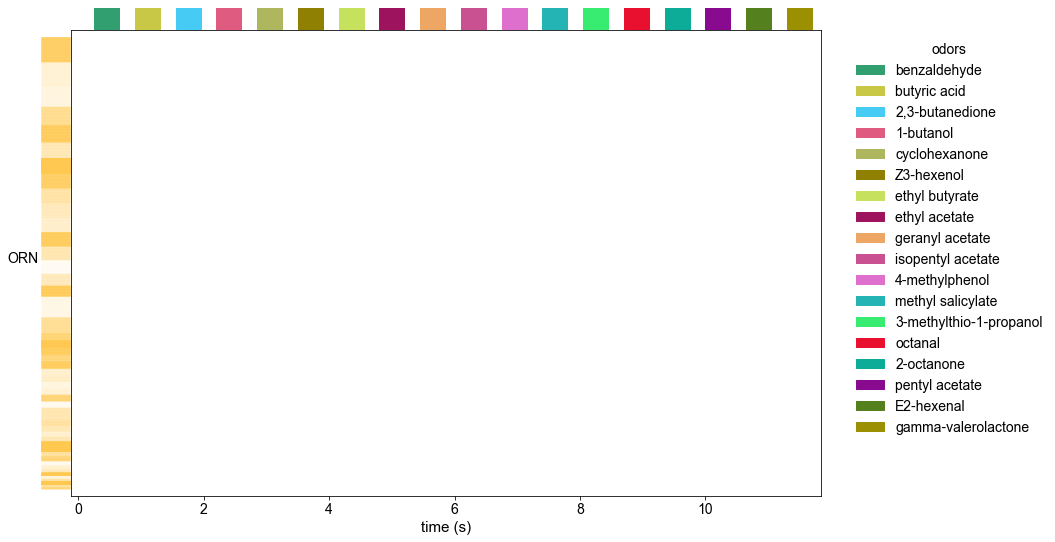

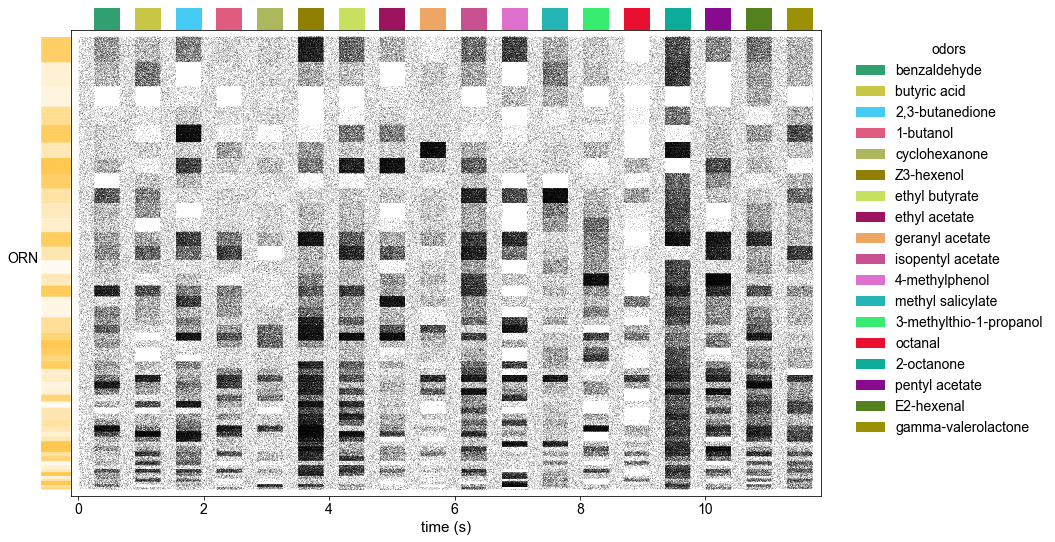

In [17]:
saveplot = 0
plt.figure(figsize=(14,9))
df_neur_ORN_only = plot_sim_raster(sim, Spikes, df_AL_activity, d_color, 
                                   plot_ORNs=True, plot_LNs_PNs=0, msize=0.15,
                                   frame_only=True)
if saveplot:
    plt.savefig(os.path.join(SUPFIG_DIR, 'raster_ORNs_only_frame.pdf'), bbox_inches='tight')
    plt.savefig(os.path.join(SUPFIG_DIR, 'raster_ORNs_only_frame.png'), bbox_inches='tight', dpi=400)
plt.show()

plt.figure(figsize=(14,9))
df_neur_ORN_only = plot_sim_raster(sim, Spikes, df_AL_activity, d_color, 
                                   plot_ORNs=True, plot_LNs_PNs=0, msize=0.15,
                                   frame_only=False)
if saveplot:
    plt.savefig(os.path.join(SUPFIG_DIR, 'raster_ORNs_only.pdf'), bbox_inches='tight')
    plt.savefig(os.path.join(SUPFIG_DIR, 'raster_ORNs_only.png'), bbox_inches='tight', dpi=400)
plt.show()

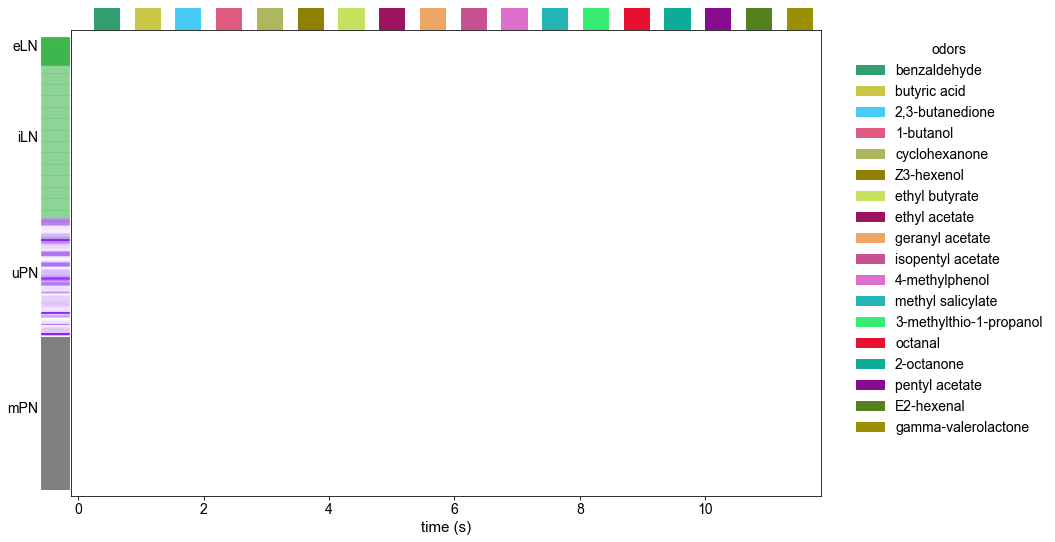

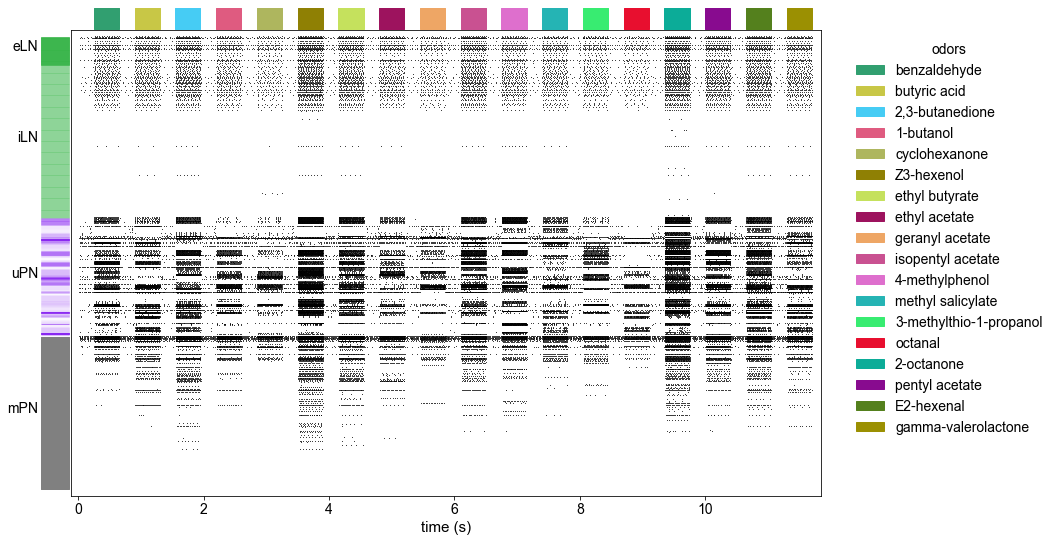

In [18]:
saveplot = 0
plt.figure(figsize=(14,9))
df_neur_LNPN = plot_sim_raster(sim, Spikes, df_AL_activity, d_color, 
                               plot_ORNs=False, plot_LNs_PNs=True, msize=1,
                               frame_only=True)
if saveplot:
    plt.savefig(os.path.join(SUPFIG_DIR, 'raster_LNs_PNs_frame.pdf'), bbox_inches='tight')
    plt.savefig(os.path.join(SUPFIG_DIR, 'raster_LNs_PNs_frame.png'), bbox_inches='tight', dpi=400)
plt.show()

plt.figure(figsize=(14,9))
df_neur_LNPN = plot_sim_raster(sim, Spikes, df_AL_activity, d_color, 
                               plot_ORNs=False, plot_LNs_PNs=True, msize=0.75,
                               frame_only=False)
if saveplot:
    plt.savefig(os.path.join(SUPFIG_DIR, 'raster_LNs_PNs.pdf'), bbox_inches='tight')
    plt.savefig(os.path.join(SUPFIG_DIR, 'raster_LNs_PNs.png'), bbox_inches='tight', dpi=500)
plt.show()

In [19]:
PLOT_DIR = '../figures/main_text_figure/'

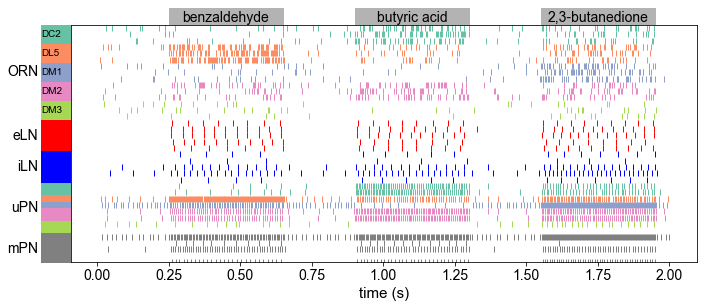

In [20]:
saveplot = 0

plt.figure(figsize=(10, 4.5))
plot_mini_raster(sim, Spikes, df_AL_activity, subsampling=15, msize=6)
if saveplot:
    plt.savefig(os.path.join(PLOT_DIR, 'mini_raster_with_mPNs.pdf'), bbox_inches='tight')
    plt.savefig(os.path.join(PLOT_DIR, 'mini_raster_with_mPNs.png'), bbox_inches='tight', dpi=200)
plt.show()  

In [21]:
model_bhand_gloms = ['DL1', 'DM1', 'DM2', 'DM3', 'DM4', 'VA2']
plot_dir = 'plot_sept23'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

In [22]:
### BHANDAWAT VERSION
df_AL_activity_bhand  = df_AL_activity.copy()[
    ((df_AL_activity.neur_type == 'ORN') & (df_AL_activity.glom.isin(model_bhand_gloms))) | 
    (df_AL_activity.neur_type.isin(['iLN', 'eLN'])) | 
    ((df_AL_activity.neur_type == 'uPN') & (df_AL_activity.glom.isin(model_bhand_gloms))) |
    (df_AL_activity.neur_type == 'mPN')
]


## ORN and PN firing rates
df_AL_activity_long_bhand = make_df_AL_activity_long(df_AL_activity_bhand)
df_orn_frs_bhand_ONOFF, df_upn_frs_bhand_ONOFF = make_orn_upn_frs(df_AL_activity_bhand, odor_names, df_neur_ids_bhand.reset_index(),
                                              sub_pre=True, olf_only=True)
df_orn_frs_bhand_ON, df_upn_frs_bhand_ON = make_orn_upn_frs(df_AL_activity_bhand, odor_names, df_neur_ids_bhand.reset_index(),
                                              sub_pre=False, olf_only=True)

In [23]:
df_orn_glom_frs_bhand_ONOFF, df_upn_glom_frs_bhand_ONOFF = \
    make_glomerular_odor_responses(df_orn_frs_bhand_ONOFF, df_upn_frs_bhand_ONOFF, df_AL_activity_bhand)

In [24]:
def plot_AL_activity_dur_pre_odors(df_AL_activity_long):
    #plt.figure(figsize=(8,3))
    
    # add expected behavior!
    cols = df_AL_activity_long.columns
    rows = [
        pd.Series(['ORN_ex_pre', 'ORN', 'fr_pre_odor0', 10, False, 0, 'DA1'], index=cols),
        pd.Series(['ORN_ex_dur', 'ORN', 'fr_dur_odor0', 40, True, 0, 'DA1'], index=cols),
        pd.Series(['LN_ex_pre', 'LN', 'fr_pre_odor0', 5, False, 0, np.nan], index=cols),
        pd.Series(['LN_ex_dur', 'LN', 'fr_dur_odor0', 10, True, 0, np.nan], index=cols),
        pd.Series(['iLN_ex_pre', 'iLN', 'fr_pre_odor0', 5, False, 0, np.nan], index=cols),
        pd.Series(['iLN_ex_dur', 'iLN', 'fr_dur_odor0', 10, True, 0, np.nan], index=cols),
        pd.Series(['eLN_ex_pre', 'eLN', 'fr_pre_odor0', 5, False, 0, np.nan], index=cols),
        pd.Series(['eLN_ex_dur',  'eLN', 'fr_dur_odor0', 10, True, 0, np.nan], index=cols),
        #pd.Series(['PN_ex_pre', 'PN', 'fr_pre_odor0', 5, False, 0, 'DA1'], index=cols),
        #pd.Series(['PN_ex_dur', 'PN', 'fr_dur_odor0', 90, True, 0, 'DA1'], index=cols),
        pd.Series(['uPN_ex_pre', 'uPN', 'fr_pre_odor0', 5, False, 0, 'DA1'], index=cols),
        pd.Series(['uPN_ex_dur', 'uPN', 'fr_dur_odor0', 90, True, 0, 'DA1'], index=cols),
        #pd.Series(['mPN_ex_pre', 'mPN', 'fr_pre_odor0', 5, False, 0, 'DA1'], index=cols),
        #pd.Series(['mPN_ex_dur', 'mPN', 'fr_dur_odor0', 90, True, 0, 'DA1'], index=cols),
    ]
    df_expected_activity = pd.DataFrame(rows)
    # use appropriate values if all LNs, or mix of i/eLNs
    df_expected_activity = (df_expected_activity
            [df_expected_activity.neur_type.isin(df_AL_activity_long.neur_type)]
    )
    
    show_violin=False
    show_means=True
    show_expect=True
    show_pts=True
    if show_violin:
        ax = sns.violinplot(x='neur_type', y='fr', 
                      hue='dur_odor', dodge=True, 
                      palette='husl',
                      alpha=0.1, linewidth=0,
                      data=df_AL_activity_long)
    if show_means:
        ax = sns.pointplot(x='neur_type', y='fr', 
                      hue='dur_odor', dodge=True, 
                      data=df_AL_activity_long,
                      palette="husl", join=False,
                      markers="d", ci=None, label='means')
    if show_expect:
        ax = sns.pointplot(x='neur_type', y='fr', 
                      hue='dur_odor', dodge=True, 
                      data=df_expected_activity,
                      palette=['gold']*2, join=False,
                      markers="*", ci=None, label='means')
    
    if show_pts:
        sns.stripplot(x='neur_type', y='fr', 
                      hue='dur_odor', dodge=True, 
                      color='k', alpha=0.25, size=3, 
                      jitter=True,
                      data=df_AL_activity_long)
    
    handles, labels = [], []#ax.get_legend_handles_labels()
    plt.legend(handles, labels,#[0:2], labels[0:2], 
              frameon=False)#title='During odor?\n(diamonds are means)\n(stars are goals)', loc='upper left')
    plt.xlabel('')
    plt.ylabel('firing rate (Hz)')
    #plt.show()

### firing rates for all neurons

In [25]:
SUPFIG_DIR = '../figures/supfig_model_literature_comparison/'

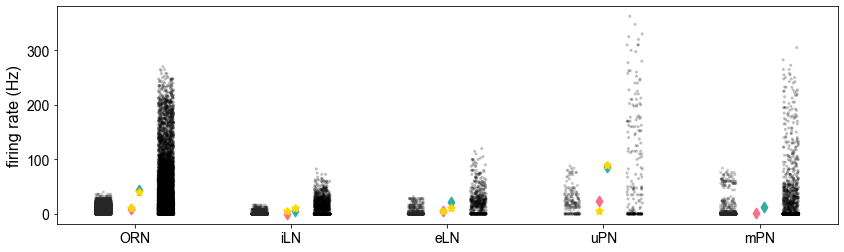

In [26]:
plt.figure(figsize=(14,4))
plot_AL_activity_dur_pre_odors(df_AL_activity_long_bhand)
saveplot=0
if saveplot:
    plt.savefig(os.path.join(SUPFIG_DIR, 'all_neuron_firing_rates.pdf'), bbox_inches='tight')
    plt.savefig(os.path.join(SUPFIG_DIR, 'all_neuron_firing_rates.png'), bbox_inches='tight', dpi=200)
plt.show()

In [27]:
df_orn_dur_odors = df_AL_activity_long_bhand[(df_AL_activity_long_bhand.neur_type == 'ORN') &
                                             (df_AL_activity_long_bhand.dur_odor)]
sum(df_orn_dur_odors['fr'] < 50) / len(df_orn_dur_odors)

0.7082747304266291

In [28]:
cols = df_AL_activity_long.columns
# rough sense of literature firing rate averages
df_lit = pd.DataFrame(np.array([
    ['ORN', 'on', 40],
    ['ORN', 'off', 10],
    ['iLN', 'on', 10],
    ['iLN', 'off', 5],
    ['eLN', 'on', 10],
    ['eLN', 'off', 5],
    ['uPN', 'on', 90],
    ['uPN', 'off', 5]
    ]), columns=['cell', 'odors_on', 'fr']
)

df_lit['fr'] = df_lit['fr'].astype(int)

ORN 8.931082981715893 8.485700890764182
iLN 73.99598393574297 91.76706827309236
eLN 30.28673835125448 65.59139784946237
uPN 33.83838383838384 26.767676767676768
mPN 80.23569023569024 92.89562289562289


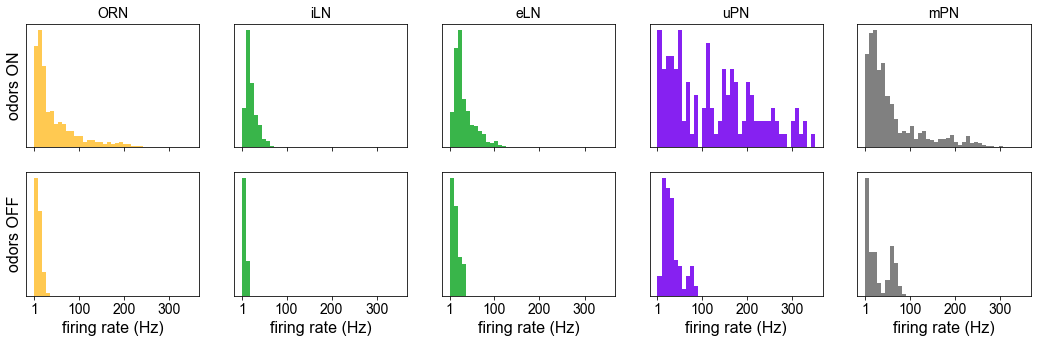

In [29]:
dfl = df_AL_activity_long_bhand
fig, axs = plt.subplots(2, 5, figsize=(18,5), sharex=True)

### ORN
# during
sub_df = dfl[(dfl.neur_type == 'ORN')]

cell_types = ['ORN', 'iLN', 'eLN', 'uPN', 'mPN']

for i in range(len(cell_types)):
    plot_col = i
    cur_cell = cell_types[i]
    
    sub_df = dfl[(dfl.neur_type == cur_cell)]
    

    minb = np.min(sub_df['fr']); maxb = np.max(sub_df['fr'])
    b = np.linspace(minb, maxb, 30)
    b = np.linspace(1, 350, 40)
    
    fr_on = sub_df[sub_df.dur_odor == 1]['fr']
    fr_off = sub_df[sub_df.dur_odor == 0]['fr']
    
    print(cur_cell, 100*sum(fr_on == 0)/len(fr_on), 100*sum(fr_off == 0)/len(fr_off))
    
    fr_on = fr_on[fr_on > 0]
    fr_off = fr_off[fr_off > 0]
    #fr_on = fr_on[(fr_on > 0) & (fr_off > 0)]
    #fr_off = fr_on[(fr_on > 0) & (fr_off > 0)]
    
    alpha=1
    if cur_cell == 'iLN':
        alpha = 0.25
    if cur_cell == 'eLN':
        alpha = 0.75
    alpha=1
    axs[0, plot_col].hist(fr_on, bins=b, alpha=alpha, color=d_color[cur_cell])
    axs[1, plot_col].hist(fr_off, bins=b, alpha=alpha, color=d_color[cur_cell])
    
    do_lines = False
    if do_lines:
        axs[0, plot_col].axvline(np.mean(fr_on), 
                                 ls='--', 
                                 color='red')#d_color[cur_cell])
        axs[1, plot_col].axvline(np.mean(fr_off), 
                                 ls='--', 
                                 color='red')#d_color[cur_cell])

        if cur_cell in df_lit['cell'].values:
            axs[0, plot_col].axvline(df_lit[(df_lit.cell == cur_cell) & (df_lit.odors_on == 'on')]['fr'].iloc[0], 
                                     #ls='--', 
                                     color='k')
            axs[1, plot_col].axvline(df_lit[(df_lit.cell == cur_cell) & (df_lit.odors_on == 'off')]['fr'].iloc[0], 
                                     #ls='--', 
                                     color='k')
    
    axs[0, plot_col].set_title(cur_cell)
    
    
    #axs[0, plot_col].semilogy(); axs[1, plot_col].semilogy()
    axs[0, plot_col].set_yticks([]); axs[1, plot_col].set_yticks([])   
    
    axs[1, plot_col].set_xlabel('firing rate (Hz)')
    axs[1, plot_col].set_xticks([1, 100, 200, 300])
    
    
axs[0, 0].set_ylabel('odors ON')
axs[1, 0].set_ylabel('odors OFF')

plt.show()

In [30]:
bhand_filepath = os.path.join(project_dir, 'datasets/Bhandawat2007/fig3_responses/fig3_firing_rates.csv')
df_bhand_frs = pd.read_csv(bhand_filepath)
df_bhand_orn_glom_by_odor = df_bhand_frs[df_bhand_frs.cell_type == 'ORN'].pivot('glomerulus', 'odor', 'firing_rate')
df_bhand_pn_glom_by_odor = df_bhand_frs[df_bhand_frs.cell_type == 'PN'].pivot('glomerulus', 'odor', 'firing_rate')        

### comparison of glomerulus-average ORN/PN firing rate histograms

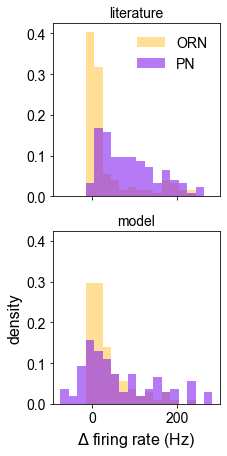

In [31]:
df_orn_frs = df_orn_glom_frs_bhand_ONOFF
df_upn_frs = df_upn_glom_frs_bhand_ONOFF

alpha = 0.6

fig, axs = plt.subplots(2, 1, figsize=(3, 7), sharex=True, sharey=True)

all_frs = np.concatenate((df_upn_frs.values.flatten(), df_orn_frs.values.flatten()))
max_fr = max(all_frs); min_fr = min(all_frs)
b = np.arange(min_fr-0.01, max_fr, 20)
    
arr = df_bhand_orn_glom_by_odor.values.flatten()
weights = np.ones_like(arr) / len(arr)
axs[0].hist(arr, weights=weights, bins=b, color=d_color['ORN'], alpha=alpha, 
        label='ORN')
arr = df_bhand_pn_glom_by_odor.values.flatten()
weights = np.ones_like(arr) / len(arr)
axs[0].hist(arr, weights=weights, bins=b, color=d_color['PN'], alpha=alpha, 
        label='PN')

axs[0].legend(frameon=False)
    
arr = df_orn_frs.values.flatten()
weights = np.ones_like(arr) / len(arr)
axs[1].hist(arr, weights=weights, bins=b, color=d_color['ORN'], alpha=alpha, 
            label='model ORNs')
arr = df_upn_frs.values.flatten()
weights = np.ones_like(arr) / len(arr)
axs[1].hist(arr, weights=weights, bins=b, color=d_color['PN'], alpha=alpha, 
        label='model PNs')
   
#axs[1].legend()
axs[1].set_xlabel(r'$\Delta$ firing rate (Hz)')
axs[1].set_ylabel('density')
axs[0].set_title('literature')
axs[1].set_title('model')

saveplot=0
if saveplot:
    plt.savefig(os.path.join(SUPFIG_DIR, 'PN_ORN_firing_rate_hist.pdf'), bbox_inches='tight')
    plt.savefig(os.path.join(SUPFIG_DIR, 'PN_ORN_firing_rate_hist.png'), bbox_inches='tight', dpi=200)

plt.show()
    

### comparison of ORN PN transfer functions

In [32]:
from sklearn.decomposition import PCA

def do_PCA(odor_by_glom_table):
    # column-center the data
    odor_by_glom_table_centered = odor_by_glom_table - odor_by_glom_table.mean(0)
    pca = PCA()
    pca.fit(odor_by_glom_table_centered)
    pca_projections = pca.transform(odor_by_glom_table_centered)[:, :2]
    return pca_projections, pca
   
    
df_bhand_frs = pd.read_csv(os.path.join(project_dir, 'datasets/Bhandawat2007/fig3_responses/fig3_firing_rates.csv'))
df_bhand_orn_glom_by_odor = df_bhand_frs[df_bhand_frs.cell_type == 'ORN'].pivot('glomerulus', 'odor', 'firing_rate').loc[bhand_gloms, odor_names]
df_bhand_pn_glom_by_odor = df_bhand_frs[df_bhand_frs.cell_type == 'PN'].pivot('glomerulus', 'odor', 'firing_rate').loc[bhand_gloms, odor_names]

bhand_ORN_projections, bhand_ORN_pca = do_PCA(df_bhand_orn_glom_by_odor.T)
bhand_PN_projections, bhand_PN_pca = do_PCA(df_bhand_pn_glom_by_odor.T)

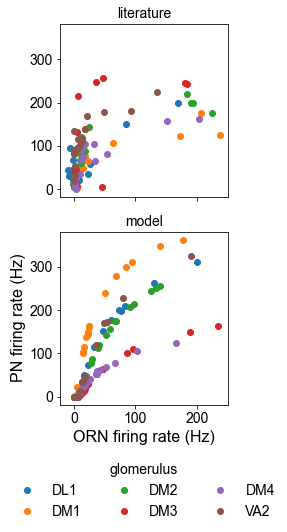

In [33]:
def plot_PN_vs_ORN_comparison_to_Bhandawat(fig, axs, orn_table, pn_table, gloms):

    for g in gloms:
        axs[1].plot(orn_table.loc[g], pn_table.loc[g], 'o', label=g)

        axs[0].plot(df_bhand_orn_glom_by_odor.loc[g], 
                    df_bhand_pn_glom_by_odor.loc[g], 'o', label=g)

    axs[1].set_title('model')
    axs[0].set_title('literature')
    axs[1].set_xlabel('ORN firing rate (Hz)')
    axs[1].set_ylabel('PN firing rate (Hz)')
    plt.legend(title='glomerulus', loc='center', frameon=False,
               bbox_to_anchor=(0.5, -0.5), ncol=3, borderaxespad=0)
    #.show()
    
# plot PN vs ORN firing rate relationship
df_orn_glom_frs_bhand_ON, df_upn_glom_frs_bhand_ON = \
    make_glomerular_odor_responses(df_orn_frs_bhand_ON, df_upn_frs_bhand_ON, df_AL_activity_bhand)

SUPFIG_DIR = '../figures/supfig_model_literature_comparison/'
saveplot=0
    
fig, axs = plt.subplots(2, 1, figsize=(3, 7), sharex=True, sharey=True)
plot_PN_vs_ORN_comparison_to_Bhandawat(fig, axs, df_orn_glom_frs_bhand_ON, df_upn_glom_frs_bhand_ON, model_bhand_gloms)
if saveplot:
    plt.savefig(os.path.join(SUPFIG_DIR, 'PN_vs_ORN_firing_rate.pdf'), bbox_inches='tight')
    plt.savefig(os.path.join(SUPFIG_DIR, 'PN_vs_ORN_firing_rate.png'), bbox_inches='tight', dpi=200)
    
plt.show()

### comparison of odors projected onto ORN or PN space

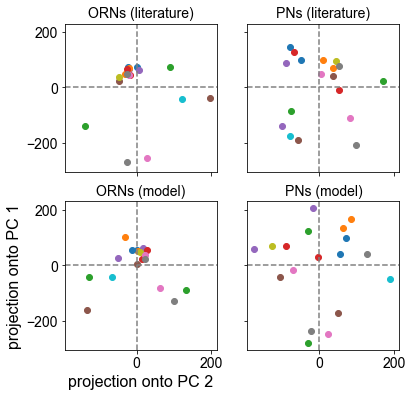

In [34]:
def plot_PCA_comparison_Bhandawat(fig, axs, bhand_ORN_projections, bhand_PN_projections, model_ORN_projections, model_PN_projections):
    
    for axset in axs:
        for ax in axset:
            ax.axvline(0, ls='--', color='0.5')
            ax.axhline(0, ls='--', color='0.5')
            
    for i in range(len(odor_names)):
        axs[0, 0].scatter(bhand_ORN_projections[i, 1], -bhand_ORN_projections[i, 0], label=odor_names[i])
        axs[0, 1].scatter(bhand_PN_projections[i, 1], -bhand_PN_projections[i, 0], label=odor_names[i])
        axs[1, 0].scatter(model_ORN_projections[i, 1], -model_ORN_projections[i, 0], label=odor_names[i])
        axs[1, 1].scatter(model_PN_projections[i, 1], -model_PN_projections[i, 0], label=odor_names[i])


    axs[0, 0].set_title('ORNs (literature)')
    axs[0, 1].set_title('PNs (literature)')    
    axs[1, 0].set_title('ORNs (model)')
    axs[1, 1].set_title('PNs (model)')
    axs[1, 0].set_xlabel('projection onto PC 2')
    axs[1, 0].set_ylabel('projection onto PC 1')

    #plt.show()
    
bhand_ORN_noVM2_projections, bhand_ORN_noVM2_pca = do_PCA(df_bhand_orn_glom_by_odor.loc[model_bhand_gloms, odor_names].T)
bhand_PN_noVM2_projections, bhand_PN_noVM2_pca = do_PCA(df_bhand_pn_glom_by_odor.loc[model_bhand_gloms, odor_names].T)


df_orn_glom_frs_bhand_ONOFF_noVM2 = df_orn_glom_frs_bhand_ONOFF.loc[model_bhand_gloms, odor_names]
df_upn_glom_frs_bhand_ONOFF_noVM2 = df_upn_glom_frs_bhand_ONOFF.loc[model_bhand_gloms, odor_names]
model_ORN_projections, model_ORN_pca = do_PCA(df_orn_glom_frs_bhand_ONOFF_noVM2.T)
model_PN_projections, model_PN_pca = do_PCA(df_upn_glom_frs_bhand_ONOFF_noVM2.T)

model_ORN_projected_to_bhand_noVM2 = bhand_ORN_noVM2_pca.transform(df_orn_glom_frs_bhand_ONOFF_noVM2.T)[:, :2]
model_PN_projected_to_bhand_noVM2 = bhand_ORN_noVM2_pca.transform(df_upn_glom_frs_bhand_ONOFF_noVM2.T)[:, :2]

fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(6, 6))
plot_PCA_comparison_Bhandawat(fig, axs, 
                              bhand_ORN_noVM2_projections, bhand_PN_noVM2_projections,
                              model_ORN_projections, model_PN_projections)
saveplot=0
if saveplot:
    plt.savefig(os.path.join(SUPFIG_DIR, 'PN_ORN_coding_space.pdf'), bbox_inches='tight')
    plt.savefig(os.path.join(SUPFIG_DIR, 'PN_ORN_coding_space.png'), bbox_inches='tight', dpi=200)

plt.show()
